#Zeroth Order Tikhonov

In [1]:
using RegularizedSystems
using VSTom
using PyPlot
using ProgressMeter

In [2]:
function make_synthetic_data{T<:Real}(A::Array{T,2},dist::Array{T,2},n::T,b::T,dE::T,dP::T)
    y = (dE*dP) * (A*vec(dist))
    
    scale = n*mean(sqrt(y))
    yerr = scale .* max(sqrt(y),sqrt(b)) .* randn(length(y))
    
    noisy_spectrum = y .+ yerr
    noisy_background = b .+ scale*sqrt(b).*randn(length(y))
    
    scale_est = n*mean(sqrt(abs(noisy_spectrum)))
    
    err = scale_est .* max(sqrt(abs(noisy_spectrum)),sqrt(abs(noisy_background)))
    
    return noisy_spectrum, err
end

make_synthetic_data (generic function with 1 method)

##Reconstruct distributions on 20x20 grid

In [3]:
nenergy = 20
npitch = 20

test_dists = read_ncdf("data/test_distributions.cdf");
test_data = read_ncdf("data/test_data.cdf")
wf   = read_ncdf("data/reduced_synthetic_transfer_matrix.cdf");

A_full = wf["transfer_matrix"]
energy_full = wf["energy"]
pitch_full  = wf["pitch"]

dE_full = abs(energy_full[2] - energy_full[1])
dP_full = abs(pitch_full[2] - pitch_full[1])
energy = linspace(20.0,maximum(energy_full),nenergy)
pitch = linspace(extrema(pitch_full)...,npitch)
A = resize_transfer_matrix(A_full,energy_full,pitch_full,energy,pitch);
dE = abs(energy[2]-energy[1])
dP = abs(pitch[2]-pitch[1]);
L1E,L1p = gradEP(energy,pitch);

In [4]:
function tik0_analysis(A_full,dist_full,dE_full,dP_full,A,dE,dP,n;num=20)
    nr,nc = size(A)
    x = zeros(nc,num)
    for i=1:num
        spec,err = make_synthetic_data(A_full,dist_full,n,1.25e14,dE_full,dP_full)
        RF = TikhonovFunctional(A,spec,err,(eye(nc),))
        alpha = lcurve(RF,log_alpha_range=(-10,5),nseeds=50)
        sol = minimize(RF,alpha)
        x[:,i] = max(sol.x,0)/(dE*dP)
    end
    
    return x
end

tik0_analysis (generic function with 1 method)

In [5]:
transp_full = test_dists["transp"]
transp = bilinear(transp_full,energy_full,pitch_full,energy,pitch)
transp_vec = vec(transp)
nr,nc = size(A)
t_x_mean = zeros(nc,20)
t_x_var = zeros(nc,20)
t_x_bias = zeros(nc,20)
t_x_mse = zeros(nc,20)

t_d_mean = zeros(20)
t_d_var = zeros(20)
t_d_bias = zeros(20)
t_d_mse = zeros(20)

@showprogress for (i,n) in enumerate(0.05:0.05:1.0)
    x_samples = tik0_analysis(A_full,transp_full,dE_full,dP_full,A,dE,dP,n)

    t_x_mean[:,i] = squeeze(mean(x_samples,2),2)
    t_x_var[:,i] = squeeze(var(x_samples,2),2)
    t_x_bias[:,i] = t_x_mean[:,i] - transp_vec
    t_x_mse[:,i] = t_x_bias[:,i].^2 + t_x_var[:,i]
    
    t_d_mean[i] = mean(sum(x_samples,1)*dE*dP)
    t_d_var[i] = var(sum(x_samples,1)*dE*dP)
    t_d_bias[i] = t_d_mean[i] - 1e12
    t_d_mse[i] = t_d_bias[i]^2 + t_d_var[i]
end

Progress: 100%|█████████████████████████████████████████| Time: 2:18:04


In [8]:
x_samples = tik0_analysis(A_full,transp_full,dE_full,dP_full,A,dE,dP,0.95)
i=19
t_x_mean[:,i] = squeeze(mean(x_samples,2),2)
t_x_var[:,i] = squeeze(var(x_samples,2),2)
t_x_bias[:,i] = t_x_mean[:,i] - transp_vec
t_x_mse[:,i] = t_x_bias[:,i].^2 + t_x_var[:,i]

t_d_mean[i] = mean(sum(x_samples,1)*dE*dP)
t_d_var[i] = var(sum(x_samples,1)*dE*dP)
t_d_bias[i] = t_d_mean[i] - 1e12
t_d_mse[i] = t_d_bias[i]^2 + t_d_var[i]

1.3283121268927466e23

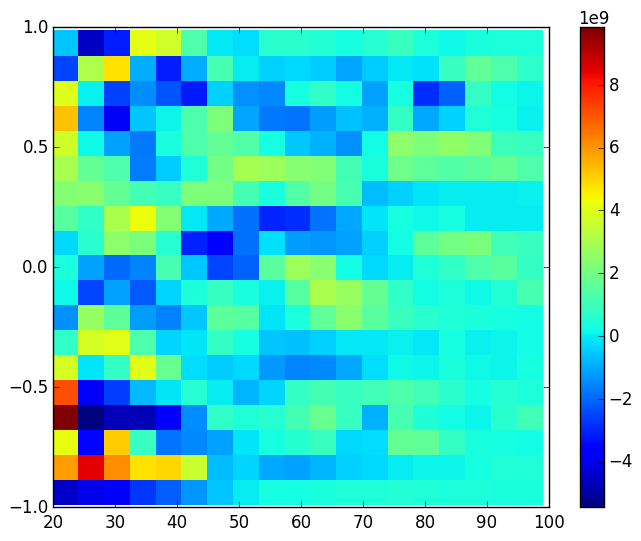

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa259544668>

In [29]:
pcolor(energy,pitch,reshape(t_x_bias[:,1],20,20))
colorbar()

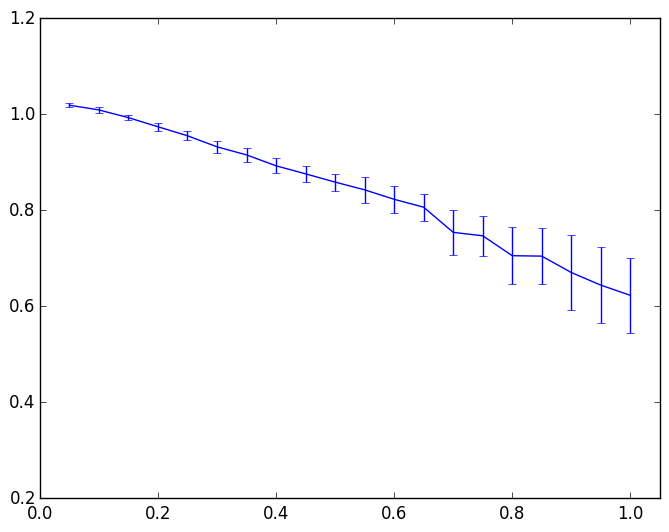

(0,1.05)

In [10]:
errorbar([0.05:0.05:1.0],t_d_mean/1e12,sqrt(t_d_var)/1e12)
ylim(0.2,1.2)
xlim(0,1.05)

In [11]:
using NetCDF
# Write synthetic data to file
fname = "data/tik0_sampled_transp.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",20*20)
ncols_id = NcDim("ncols",20)
nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_mean_varid = NcVar("x_mean",[nrows_id,ncols_id])
x_var_varid = NcVar("x_var",[nrows_id,ncols_id])
x_bias_varid = NcVar("x_bias",[nrows_id,ncols_id])
x_mse_varid = NcVar("x_mse",[nrows_id,ncols_id])

d_mean_varid = NcVar("d_mean",ncols_id)
d_var_varid = NcVar("d_var",ncols_id)
d_bias_varid = NcVar("d_bias",ncols_id)
d_mse_varid = NcVar("d_mse",ncols_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",nen_id)
elevel_varid = NcVar("error_level",ncols_id)

ncid = NetCDF.create(fname,[x_mean_varid,x_var_varid,x_bias_varid,x_mse_varid,
    d_mean_varid,d_var_varid,d_bias_varid,d_mse_varid,energy_varid,pitch_varid,elevel_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_mean",t_x_mean)
NetCDF.putvar(ncid,"x_var",t_x_var)
NetCDF.putvar(ncid,"x_bias",t_x_bias)
NetCDF.putvar(ncid,"x_mse",t_x_mse)

NetCDF.putvar(ncid,"d_mean",t_d_mean)
NetCDF.putvar(ncid,"d_var",t_d_var)
NetCDF.putvar(ncid,"d_bias",t_d_bias)
NetCDF.putvar(ncid,"d_mse",t_d_mse)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)
NetCDF.putvar(ncid,"error_level",[0.05:0.05:1.0])
NetCDF.close(ncid);

In [5]:
gaussian_full = test_dists["gaussian"]
gaussian = bilinear(gaussian_full,energy_full,pitch_full,energy,pitch)
gaussian_vec = vec(gaussian)
nr,nc = size(A)
g_x_mean = zeros(nc,20)
g_x_var = zeros(nc,20)
g_x_bias = zeros(nc,20)
g_x_mse = zeros(nc,20)

g_d_mean = zeros(20)
g_d_var = zeros(20)
g_d_bias = zeros(20)
g_d_mse = zeros(20);

In [6]:
@showprogress for (i,n) in enumerate(0.05:0.05:1.0)
    x_samples = tik0_analysis(A_full,gaussian_full,dE_full,dP_full,A,dE,dP,n)

    g_x_mean[:,i] = squeeze(mean(x_samples,2),2)
    g_x_var[:,i] = squeeze(var(x_samples,2),2)
    g_x_bias[:,i] = g_x_mean[:,i] - gaussian_vec
    g_x_mse[:,i] = g_x_bias[:,i].^2 + g_x_var[:,i]
    
    g_d_mean[i] = mean(sum(x_samples,1)*dE*dP)
    g_d_var[i] = var(sum(x_samples,1)*dE*dP)
    g_d_bias[i] = g_d_mean[i] - 1e12
    g_d_mse[i] = g_d_bias[i]^2 + g_d_var[i]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:53:06


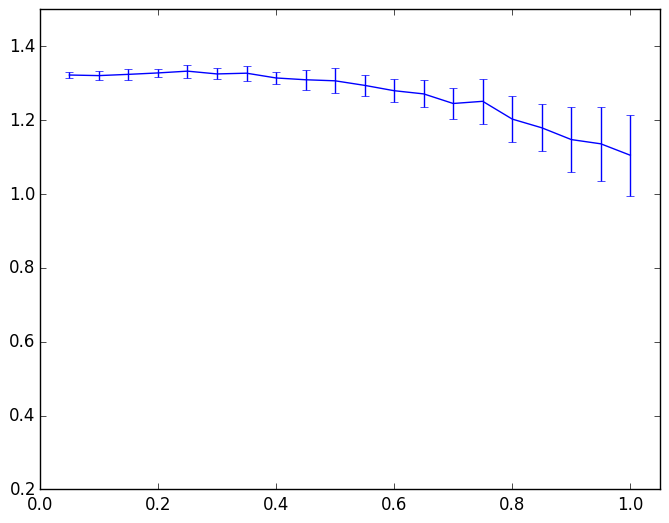

(0,1.05)

In [8]:
errorbar([0.05:0.05:1.0],g_d_mean/1e12,sqrt(g_d_var)/1e12)
ylim(0.2,1.5)
xlim(0,1.05)

In [9]:
using NetCDF
# Write synthetic data to file
fname = "data/tik0_sampled_gaussian.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",20*20)
ncols_id = NcDim("ncols",20)
nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_mean_varid = NcVar("x_mean",[nrows_id,ncols_id])
x_var_varid = NcVar("x_var",[nrows_id,ncols_id])
x_bias_varid = NcVar("x_bias",[nrows_id,ncols_id])
x_mse_varid = NcVar("x_mse",[nrows_id,ncols_id])

d_mean_varid = NcVar("d_mean",ncols_id)
d_var_varid = NcVar("d_var",ncols_id)
d_bias_varid = NcVar("d_bias",ncols_id)
d_mse_varid = NcVar("d_mse",ncols_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",nen_id)
elevel_varid = NcVar("error_level",ncols_id)

ncid = NetCDF.create(fname,[x_mean_varid,x_var_varid,x_bias_varid,x_mse_varid,
    d_mean_varid,d_var_varid,d_bias_varid,d_mse_varid,energy_varid,pitch_varid,elevel_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_mean",g_x_mean)
NetCDF.putvar(ncid,"x_var",g_x_var)
NetCDF.putvar(ncid,"x_bias",g_x_bias)
NetCDF.putvar(ncid,"x_mse",g_x_mse)

NetCDF.putvar(ncid,"d_mean",g_d_mean)
NetCDF.putvar(ncid,"d_var",g_d_var)
NetCDF.putvar(ncid,"d_bias",g_d_bias)
NetCDF.putvar(ncid,"d_mse",g_d_mse)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)
NetCDF.putvar(ncid,"error_level",[0.05:0.05:1.0])
NetCDF.close(ncid);

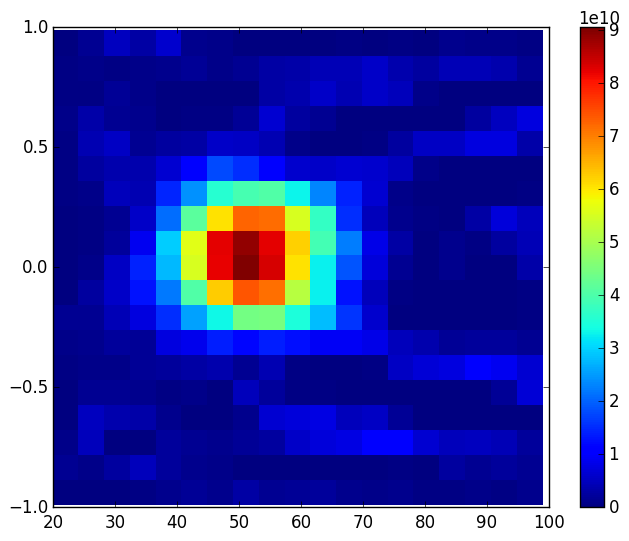

PyObject <matplotlib.colorbar.Colorbar object at 0x7f451ec96588>

In [10]:
pcolor(energy,pitch,reshape(g_x_mean[:,1],20,20))
colorbar()

In [11]:
bimax_full = test_dists["bimax"]
bimax = bilinear(bimax_full,energy_full,pitch_full,energy,pitch)
bimax_vec = vec(bimax)
nr,nc = size(A)
b_x_mean = zeros(nc,20)
b_x_var = zeros(nc,20)
b_x_bias = zeros(nc,20)
b_x_mse = zeros(nc,20)

b_d_mean = zeros(20)
b_d_var = zeros(20)
b_d_bias = zeros(20)
b_d_mse = zeros(20);

In [12]:
@showprogress for (i,n) in enumerate(0.05:0.05:1.0)
    x_samples = tik0_analysis(A_full,bimax_full,dE_full,dP_full,A,dE,dP,n)

    b_x_mean[:,i] = squeeze(mean(x_samples,2),2)
    b_x_var[:,i] = squeeze(var(x_samples,2),2)
    b_x_bias[:,i] = b_x_mean[:,i] - bimax_vec
    b_x_mse[:,i] = b_x_bias[:,i].^2 + b_x_var[:,i]
    
    b_d_mean[i] = mean(sum(x_samples,1)*dE*dP)
    b_d_var[i] = var(sum(x_samples,1)*dE*dP)
    b_d_bias[i] = b_d_mean[i] - 1e12
    b_d_mse[i] = b_d_bias[i]^2 + b_d_var[i]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:51:40


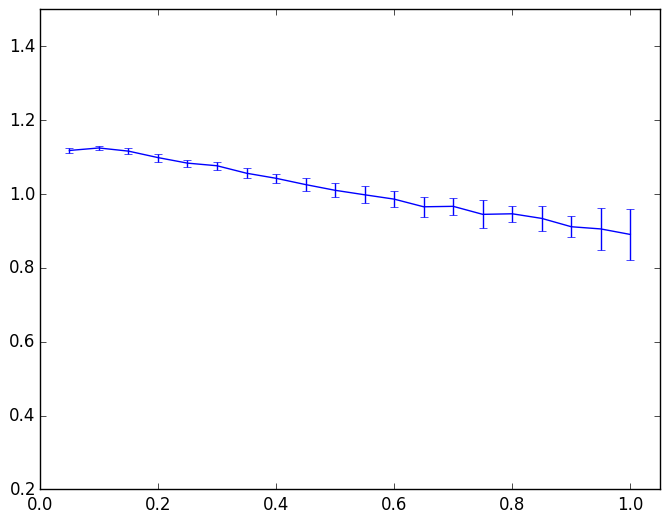

(0,1.05)

In [13]:
errorbar([0.05:0.05:1.0],b_d_mean/1e12,sqrt(b_d_var)/1e12)
ylim(0.2,1.5)
xlim(0,1.05)

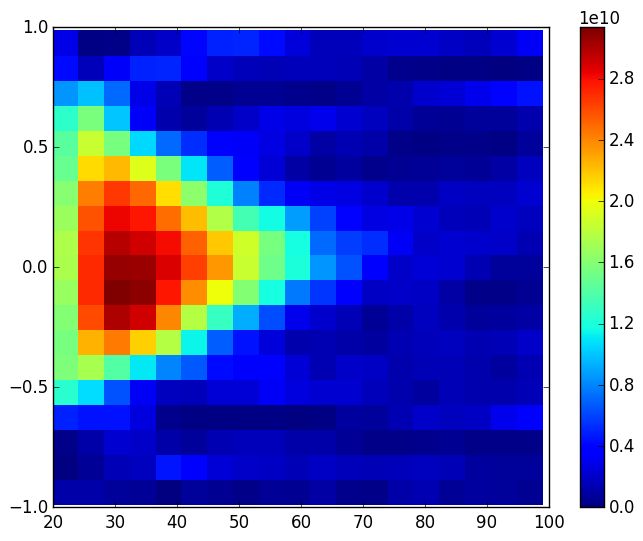

PyObject <matplotlib.colorbar.Colorbar object at 0x7f45170fbb70>

In [16]:
pcolor(energy,pitch,reshape(b_x_mean[:,15],20,20))
colorbar()

In [14]:
using NetCDF
# Write synthetic data to file
fname = "data/tik0_sampled_bimax.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",20*20)
ncols_id = NcDim("ncols",20)
nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_mean_varid = NcVar("x_mean",[nrows_id,ncols_id])
x_var_varid = NcVar("x_var",[nrows_id,ncols_id])
x_bias_varid = NcVar("x_bias",[nrows_id,ncols_id])
x_mse_varid = NcVar("x_mse",[nrows_id,ncols_id])

d_mean_varid = NcVar("d_mean",ncols_id)
d_var_varid = NcVar("d_var",ncols_id)
d_bias_varid = NcVar("d_bias",ncols_id)
d_mse_varid = NcVar("d_mse",ncols_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",nen_id)
elevel_varid = NcVar("error_level",ncols_id)

ncid = NetCDF.create(fname,[x_mean_varid,x_var_varid,x_bias_varid,x_mse_varid,
    d_mean_varid,d_var_varid,d_bias_varid,d_mse_varid,energy_varid,pitch_varid,elevel_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_mean",b_x_mean)
NetCDF.putvar(ncid,"x_var",b_x_var)
NetCDF.putvar(ncid,"x_bias",b_x_bias)
NetCDF.putvar(ncid,"x_mse",b_x_mse)

NetCDF.putvar(ncid,"d_mean",b_d_mean)
NetCDF.putvar(ncid,"d_var",b_d_var)
NetCDF.putvar(ncid,"d_bias",b_d_bias)
NetCDF.putvar(ncid,"d_mse",b_d_mse)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)
NetCDF.putvar(ncid,"error_level",[0.05:0.05:1.0])
NetCDF.close(ncid);

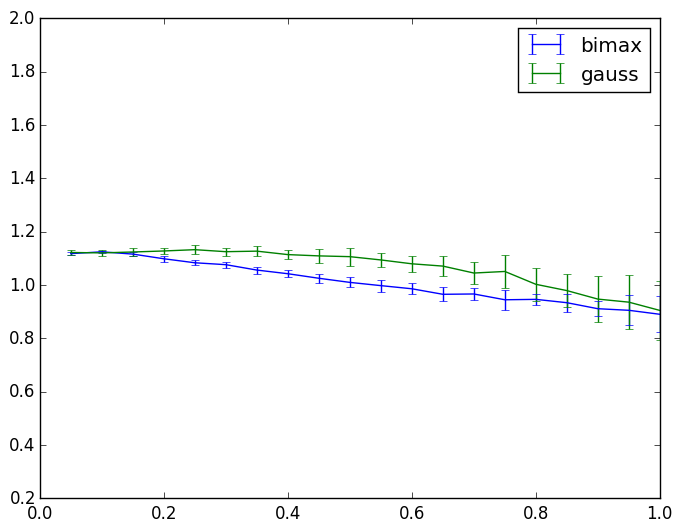

(0.2,2)

In [19]:
errorbar([0.05:0.05:1.0],b_d_mean/1e12,sqrt(b_d_var)/1e12,label="bimax")
errorbar([0.05:0.05:1.0],g_d_mean/1e12,sqrt(g_d_var)/1e12,label="gauss")
#errorbar([0.05:0.05:1.0],t_d_mean/1e12,sqrt(t_d_var)/1e12,label="transp")
legend()
ylim(0.2,2)

In [3]:
function tik0_analysis(A,spec,err,dist,dE,dP,L1E,L1p)
    nr,nc = size(A)
    RF = TikhonovFunctional(A,spec,err,(eye(nc),))
    alpha = lcurve(RF;log_alpha_range=(-10,5))
    sol = minimize(RF,alpha,true_sol=dist*dE*dP)
    dens = sum(max(sol.x,0.0))
    dens_err = norm(sol.sigma)
    x = reshape(max(sol.x,0)/(dE*dP),size(dist)...)
    sigma = reshape(sol.sigma/(dE*dP),size(dist)...)
    reg_err = reshape(sol.reg_err/(dE*dP),size(dist)...)
    dx = x .- dist
    return x,sigma,reg_err,dx,dens,dens_err
end

tik0_analysis (generic function with 1 method)

##Gaussian Reconstruction

In [4]:
gaussian_full = test_dists["gaussian"]
gaussian = bilinear(gaussian_full,energy_full,pitch_full,energy,pitch)

gauss_spec = test_data["gaussian_spec"]
gauss_err = test_data["gaussian_err"];
gauss_x = zeros(npitch,nenergy,20)
gauss_sigma = zeros(npitch,nenergy,20)
gauss_reg = zeros(npitch,nenergy,20)
gauss_dx = zeros(npitch,nenergy,20)
gauss_dens = zeros(20)
gauss_dens_err = zeros(20);

In [5]:
@showprogress for i=1:20
    gauss_x[:,:,i],gauss_sigma[:,:,i],gauss_reg[:,:,i],gauss_dx[:,:,i],gauss_dens[i],gauss_dens_err[i] = 
    tik0_analysis(A,gauss_spec[:,i+1],gauss_err[:,i+1],gaussian,dE,dP,L1E,L1p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:55


In [6]:
write_to_file(A,energy,pitch,gauss_x,gauss_sigma,gauss_reg,gaussian,gauss_dx,gauss_dens,gauss_dens_err,"data/gaussian_tik0.cdf");

##Bi-Maxwellian Reconstruction

In [7]:
bimax_full = test_dists["bimax"]
bimax = bilinear(bimax_full,energy_full,pitch_full,energy,pitch)

bimax_spec = test_data["bimax_spec"]
bimax_err = test_data["bimax_err"];
bimax_x = zeros(npitch,nenergy,20)
bimax_sigma = zeros(npitch,nenergy,20)
bimax_reg = zeros(npitch,nenergy,20)
bimax_dx = zeros(npitch,nenergy,20)
bimax_dens = zeros(20)
bimax_dens_err = zeros(20);

In [8]:
@showprogress for i=1:20
    bimax_x[:,:,i],bimax_sigma[:,:,i],bimax_reg[:,:,i],bimax_dx[:,:,i],bimax_dens[i],bimax_dens_err[i] = 
    tik0_analysis(A,bimax_spec[:,i+1],bimax_err[:,i+1],bimax,dE,dP,L1E,L1p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:11


In [9]:
write_to_file(A,energy,pitch,bimax_x,bimax_sigma,bimax_reg,bimax,bimax_dx,bimax_dens,bimax_dens_err,"data/bimax_tik0.cdf");

##TRANSP Reconstruction

In [4]:
transp_full = test_dists["transp"]
transp = bilinear(transp_full,energy_full,pitch_full,energy,pitch)

transp_spec = test_data["transp_spec"]
transp_err = test_data["transp_err"];
transp_x = zeros(npitch,nenergy,20)
transp_sigma = zeros(npitch,nenergy,20)
transp_reg = zeros(npitch,nenergy,20)
transp_dx = zeros(npitch,nenergy,20)
transp_dens = zeros(20)
transp_dens_err = zeros(20);

In [22]:
@showprogress for i=1:20
    spec = transp_spec[:,i+1]
    err = transp_spec[:,i+1]
    transp_x[:,:,i],transp_sigma[:,:,i],transp_reg[:,:,i],transp_dx[:,:,i],transp_dens[i],transp_dens_err[i] = 
    tik0_analysis(A,spec,err,transp,dE,dP,L1E,L1p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:60


In [12]:
write_to_file(A,energy,pitch,transp_x,transp_sigma,transp_reg,transp,transp_dx,transp_dens,transp_dens_err,"data/transp_tik0.cdf");

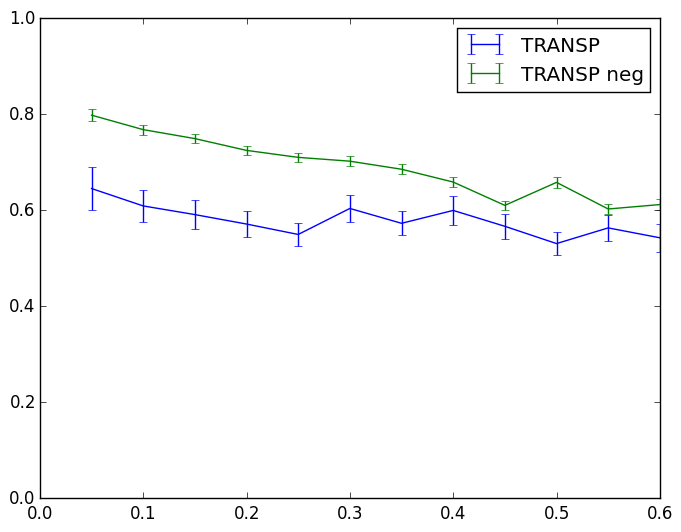

PyObject <matplotlib.legend.Legend object at 0x7f2aede59ba8>

In [26]:
errorbar([0.05:0.05:1.0],transp_dens/(1e12),transp_dens_err/(1e12),label="TRANSP")
errorbar([0.05:0.05:1.0],bimax_dens/(1e12),bimax_dens_err/(1e12),label="Bimax")
errorbar([0.05:0.05:1.0],gauss_dens/(1e12),gauss_dens_err/(1e12),label="Gaussian")
legend()